# Analyzing Chinook Database using SQL and Python
---

We'll be working with a modified version of a database called [Chinook](https://github.com/lerocha/chinook-database). The Chinook database contains information about a fictional digital music shop.

The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables.

The Chinook database is provided as a SQLite database file called `chinook.db`. It's worth remembering that our database retains 'state', so if we run a query with a `CREATE` or `DROP` twice, the query will fail. If the database gets locked, there's a `chinook-unmodified.db` file that can be copied over the `chinook.db` to restore it back to its initial state.

Here's a schema diagram for the Chinook database:

![alt text](chinook-schema.svg)

## Defining Helper Functions

In [13]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
%matplotlib inline

In [14]:
db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q,conn)

In [15]:
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c) 

In [16]:
def show_tables():
    q = '''
        SELECT
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table","view");
        '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. 

All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| __Artist Name__    | __Genre__ |
|:------------------:|:---------:|
|Regal               |Hip-Hop    |
|Red Tone            |Punk       |
|Meteor and the Girls|Pop        |
|Slim Jim Bites      |Blues      |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

In [17]:
albums_to_purchase = '''
WITH 
    usa_tracks_sold AS
        (
         SELECT il.* FROM invoice_line il
         INNER JOIN invoice i ON il.invoice_id = i.invoice_id
         INNER JOIN customer c ON i.customer_id = c.customer_id
         WHERE c.country = "USA" 
        )
SELECT 
    g.name Genre, 
    COUNT(uts.invoice_line_id) "Number of Tracks Sold", 
    CAST(COUNT(uts.invoice_line_id) AS FLOAT)/(SELECT COUNT(*) FROM usa_tracks_sold) "Percentage of Tracks Sold"
FROM usa_tracks_sold uts
INNER JOIN track t ON uts.track_id = t.track_id
INNER JOIN genre g ON t.genre_id = g.genre_id
GROUP BY 1 
ORDER BY 2 DESC
LIMIT 10;
'''

run_query(albums_to_purchase)

,Genre,Number of Tracks Sold,Percentage of Tracks Sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Pop,22,0.020932
7,Latin,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


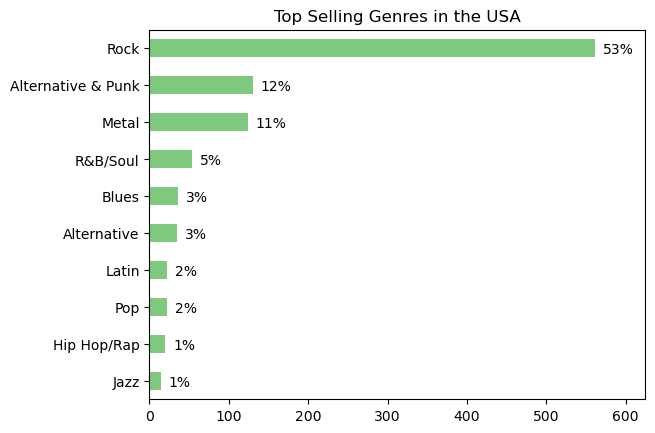

In [18]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index('Genre', drop=True, inplace=True)
genre_sales_usa.sort_values('Number of Tracks Sold', inplace=True)
genre_sales_usa['Number of Tracks Sold'].plot.barh(
        title="Top Selling Genres in the USA",
        xlim=(0, 625),
        colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "Number of Tracks Sold"]
    label = (genre_sales_usa.loc[label, "Percentage of Tracks Sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

### Observations

Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

## Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [19]:
employee_sales_performance = '''
WITH 
    customer_support_rep_sales AS
        (
         SELECT 
             i.customer_id,
             c.support_rep_id,
             SUM(i.total) Sales_Total
         FROM invoice i
         INNER JOIN customer c ON c.customer_id = i.customer_id
         GROUP BY 2
        )
SELECT
    e.first_name || " " || e.last_name "Employee Name",
    e.hire_date "Hire Date",
    SUM(csrs.Sales_total) "Amount of Sales (in $)"
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON csrs.support_rep_id = e.employee_id
GROUP BY 1;
'''

run_query(employee_sales_performance)

,Employee Name,Hire Date,Amount of Sales (in $)
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


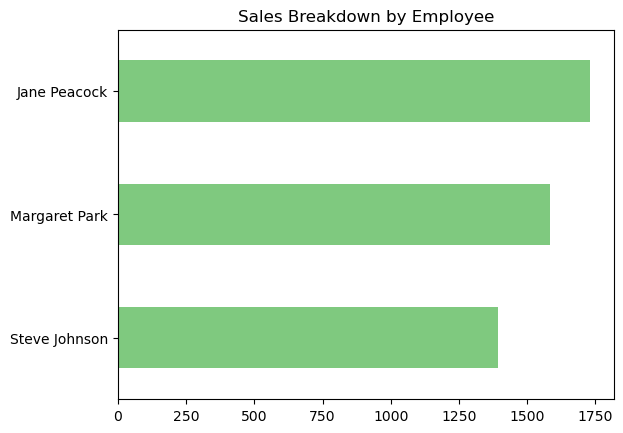

In [20]:
employee_sales = run_query(employee_sales_performance)

employee_sales.set_index("Employee Name", drop=True, inplace=True)
employee_sales.sort_values("Amount of Sales (in $)", inplace=True)
employee_sales.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
    colormap=plt.cm.Accent
)
plt.ylabel('')
plt.show()

### Observations

While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.

## Analyzing Sales by Country

Our next task is to analyze the sales data for customers from each different country. We have been given guidance to use the country value from the `customers` table, and ignore the country from the billing address in the `invoice` table.

In particular, you have been directed to calculate data, for each country, on the:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

Because there are a number of countries with only one customer, we should group these customers as "Other" in our analysis.

In [21]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country Country,
    customers "Total Number of Customers",
    total_sales "Total Sales",
    average_order "Average Order Value",
    customer_lifetime_value "Average Value of Sales per Customer"
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,Country,Total Number of Customers,Total Sales,Average Order Value,Average Value of Sales per Customer
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


## Visualizing Sales by Country

Now that we have our data, we've been asked to create a series of visualizations which communicate our findings, and then make recommendations on which countries may have potential for growth, so the Chinook marketing team can create some new advertising campaigns.

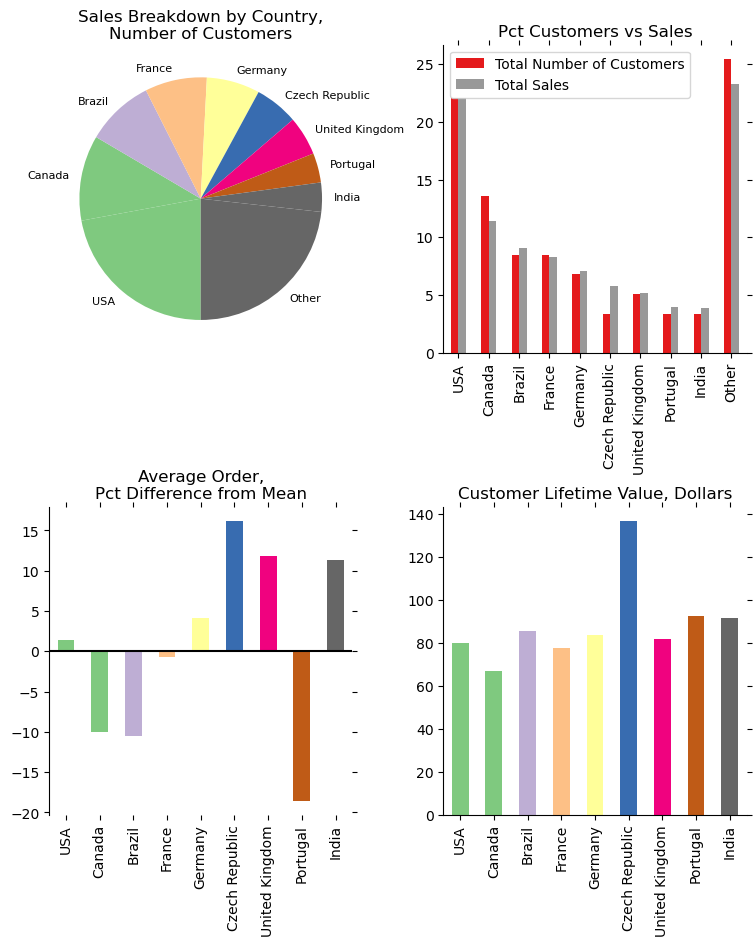

In [22]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("Country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

# top left
sales_breakdown = country_metrics["Total Sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
)

# top right
cvd_cols = ["Total Number of Customers","Total Sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["Average Order Value"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["Average Value of Sales per Customer"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

## Albums vs Individual Tracks, Part 1

The Chinook store allows customers to either purchase a whole album, or to purchase one or more individual tracks.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to make their decision.

In order to answer this question, we're going to have to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.

In [23]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT 
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )
SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(COUNT(invoice_id) AS float)/(SELECT COUNT(*) FROM invoice) percent
FROM
    (
     SELECT
         ift.*,
         CASE
             WHEN (
                 SELECT
                     t.track_id
                 FROM track t
                 WHERE t.album_id = (
                                      SELECT
                                          t2.album_id
                                      FROM track t2
                                      WHERE t2.track_id = ift.first_track_id
                 )
                 EXCEPT
                    SELECT
                        il2.track_id 
                    FROM invoice_line il2
                    WHERE il2.invoice_id = ift.invoice_id
                   )
              IS NULL THEN "YES"
              ELSE "NO"
              END AS album_purchase
      FROM invoice_first_track ift  
    )
GROUP BY album_purchase;
'''
run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,NO,497,0.809446
1,YES,117,0.190554


## Albums vs Individual Tracks, Part 2

There is an extra layer of complexity that we haven't accounted for in our previous query - the Chinook store prevents customers from buying the same track twice, so an album purchase won't include every track from the album if the customer already owns one or more tracks.

We'll need to account for this in our query. Instead of comparing just the tracks from that purchase to the tracks in the album, we'll also have to take into account all tracks purchased by that user, from that album, up until that particular invoice.

In [24]:
albums_vs_tracks_2 = '''
WITH invoice_first_track AS
    (
     SELECT 
         il.invoice_id invoice_id,
         i.customer_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     GROUP BY 1
    )
SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(COUNT(invoice_id) AS float)/(SELECT COUNT(*) FROM invoice) percent
FROM
    (
     SELECT
         ift.*,
         t.album_id,
         CASE
             WHEN (
                    SELECT
                        t3.track_id
                    FROM track t3
                    WHERE t3.album_id = t.album_id
                 
                    EXCEPT
                 
                    SELECT
                        il2.track_id 
                    FROM invoice_line il2
                    INNER JOIN invoice i2 ON i2.invoice_id = il2.invoice_id
                    INNER JOIN track t2 ON t2.track_id = il2.track_id
                    WHERE il2.invoice_id <= ift.invoice_id
                    AND i2.customer_id = ift.customer_id
                    AND t2.album_id = t.album_id
                   )
              IS NULL THEN "YES"
              ELSE "NO"
              END AS album_purchase
      FROM invoice_first_track ift
      INNER JOIN track t ON ift.first_track_id = t.track_id
    )
GROUP BY 1;
'''
run_query(albums_vs_tracks_2)

,album_purchase,number_of_invoices,percent
0,NO,475,0.773616
1,YES,139,0.226384


### Observations

Album purchases account for 22.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.